This analysis aims to define the layers of the cortex using electrophysiological markers. The analysis is based on techniques described in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6367010/?report=reader, by Senzai et al. With help from blob:https://teams.microsoft.com/36633cb2-bb93-473d-9c1e-74b267ae9d6d.

In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, fftpack, integrate

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [4]:
%matplotlib notebook

#### Functions

In [5]:
# get event triggered firing rates USING find_nearest_ind
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate) * 1000 # puts time axis in ms
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [6]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

### Define data path

In [7]:
rec_folder = r'F:\EEG_exp\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [8]:
probe_list = [i.replace('_sorted', '') for i in exp.experiment_data if 'sorted' in i]
print(probe_list)

['probeB', 'probeC']


#### Load stim table

In [9]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,70,82.58399,82.58439,0.0004,0,True
1,biphasic,50,86.48837,86.48877,0.0004,0,True
2,biphasic,50,90.16804,90.16844,0.0004,0,True
3,biphasic,50,94.63739,94.63779,0.0004,0,True
4,biphasic,50,98.54527,98.54567,0.0004,0,True


## Depth profile of high-frequency LFP power (500 Hz - 5 kHz)

Load the AP continuous data (using memmap) and the associated timestamps.

In [10]:
apcont = {}
for probex in probe_list:
    rawmm = np.memmap(exp.ephys_params[probex]['ap_continuous'], dtype='int16', mode='r')
    ap_data_mm = np.reshape(rawmm, (int(rawmm.size/exp.ephys_params[probex]['num_chs']), exp.ephys_params[probex]['num_chs']))
    ap_ts = np.load(exp.ephys_params[probex]['ap_timestamps'])
    
    apcont[probex] = [ap_ts, ap_data_mm]

Get iso times, so we can focus analysis on only awake time.

Can I load the whole awake-time array?

Try looking at pre-stim time, it's shorter.

In [11]:
pre_stim_data = {}
for probex, datax in apcont.items():
    pre_stim_inds = datax[0] < stim_log.onset.iloc[0]
    pre_stim_data[probex] = [datax[0][pre_stim_inds], datax[1][pre_stim_inds, :]]

Load probe_info.json.

In [12]:
probe_chs = {}
for probex in probe_list:
    with open(exp.ephys_params[probex]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical position of each electrode (um), relative to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels
    print('{} brain surface channel: {:d}'.format(probex, surface_ch))

    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
    npx_ch_depths = allch_z[surface_ch] - allch_z[npx_chs]
    probe_chs[probex] = [npx_chs, npx_ch_depths]

probeB brain surface channel: 280
probeC brain surface channel: 300


Use Welch's method to compute power spectral density for each electrode.

In [14]:
## Define window length ##
WINDOW = 1. # s
## Define freqs of interest lower and upper limits ##
LOW, HIGH = 500, 5000

norm_power = {}
for probex, datax in pre_stim_data.items():
    norm_power[probex] = {}
    win = WINDOW * exp.ephys_params[probex]['ap_sample_rate']
    ## Compute Welch's ##
    freqs, psd = signal.welch(datax[1], exp.ephys_params[probex]['ap_sample_rate'], nperseg=win, axis=0)
    
    ## Find intersecting values in frequency vector ##
    idx_delta = np.logical_and(freqs >= LOW, freqs <= HIGH)
    ## Compute the absolute power by approximating the area under the curve using Simpson's rule ##
    band_power = integrate.simps(psd[idx_delta], dx=freqs[1] - freqs[0], axis=0)
    
    ## Get power by depth and normalize ##
    even_chs = np.array([i for i in probe_chs[probex][0] if i%2 == 0])
    odd_chs = np.array([i for i in probe_chs[probex][0] if i%2 != 0])
    
    norm_power[probex]['even'] = [
        band_power[even_chs] / np.max(band_power[even_chs]),
        np.array([probe_chs[probex][1][probe_chs[probex][0]==i][0] for i in even_chs])
    ]
    norm_power[probex]['odd'] = [
        band_power[odd_chs] / np.max(band_power[odd_chs]),
        np.array([probe_chs[probex][1][probe_chs[probex][0]==i][0] for i in odd_chs])
    ]

<IPython.core.display.Javascript object>


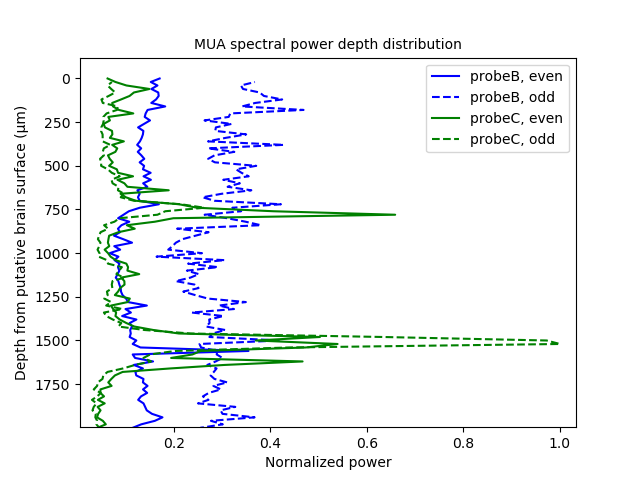

In [18]:
pcolors = {'probeB': 'b', 'probeC': 'g'}
fig, ax = plt.subplots()
for probex, chset in norm_power.items():
    ax.plot(chset['even'][0], chset['even'][1], pcolors[probex], linestyle='-', label='{}, even'.format(probex))
    ax.plot(chset['odd'][0], chset['odd'][1], pcolors[probex], linestyle='--', label='{}, odd'.format(probex))

ax.invert_yaxis()
ax.set_xlabel('Normalized power')
ax.set_ylabel('Depth from putative brain surface (\u03BCm)')
ax.set_title('MUA spectral power depth distribution')
ax.legend()

## For one probe only

Use Welch's method to compute power spectral density for each electrode.

In [13]:
## Define window length ##
win = 1 * exp.ephys_params[plot_probe]['ap_sample_rate']
# Window duration directly impacts the freq resolution of the computation (Fres = 1 / t_win).
# Optimal window duration is commonly chosen to be 2 full cycles of the lowest freq of interest.

## Compute Welch's ##
freqs, psd = signal.welch(apdata, exp.ephys_params[plot_probe]['ap_sample_rate'], nperseg=win, axis=0)

In [14]:
print(freqs.shape)
print(psd.shape)

(15001,)
(15001, 384)


<IPython.core.display.Javascript object>


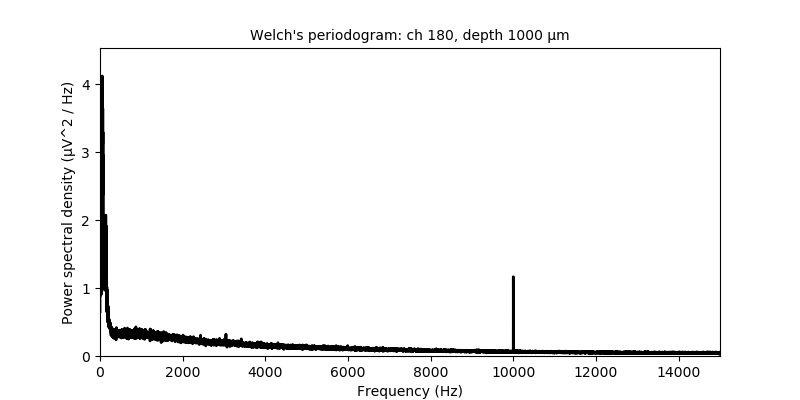

(0, 15000.0)

In [26]:
## Plot the power spectrum for one electrode ##
plot_ch = 180

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(freqs, psd[:, plot_ch], color='k', lw=2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power spectral density (\u03BCV^2 / Hz)')
ax.set_ylim([0, psd[:, plot_ch].max() * 1.1])
ax.set_title("Welch's periodogram: ch {:d}, depth {:d} \u03BCm".format(plot_ch, npx_ch_depths[npx_chs==plot_ch][0]))
ax.set_xlim([0, freqs.max()])

Define frequency band to average power over.

In [27]:
## Define freqs of interest lower and upper limits ##
low, high = 500, 5000

## Find intersecting values in frequency vector ##
idx_delta = np.logical_and(freqs >= low, freqs <= high)

Use Simpson's rule (scipy.integrate.simps) to find the area under the spectral curve within the frequency range.

In [30]:
## Compute the absolute power by approximating the area under the curve ##
freq_res = freqs[1] - freqs[0]
band_power = integrate.simps(psd[idx_delta], dx=freq_res, axis=0)
print('Absolute power of ch {:d} in band ({:d}-{:d} Hz): {:.3f} \u03BCV^2'.format(plot_ch, low, high, band_power[plot_ch]))

Absolute power of ch 180 in band (500-5000 Hz): 973.895 μV^2


Get power by depth and normalize.

In [51]:
a_chs = np.array([i for i in npx_chs if i%2 == 0])
a_depths = np.array([npx_ch_depths[npx_chs==i][0] for i in a_chs])
a_norm_power = band_power[a_chs] / np.max(band_power[a_chs])

In [52]:
b_chs = np.array([i for i in npx_chs if i%2 != 0])
b_depths = np.array([npx_ch_depths[npx_chs==i][0] for i in b_chs])
b_norm_power = band_power[b_chs] / np.max(band_power[b_chs])

<IPython.core.display.Javascript object>


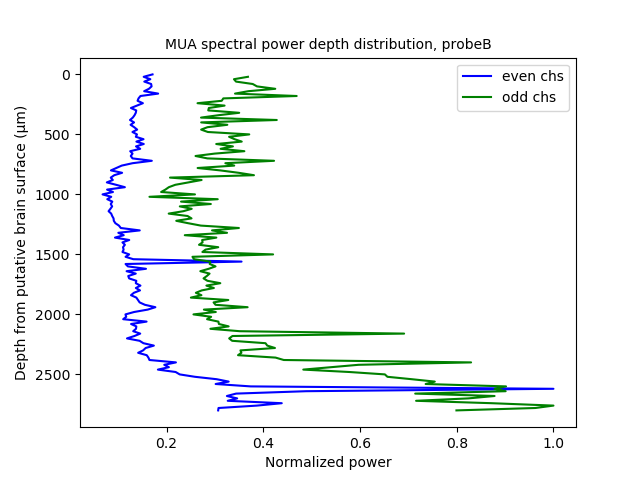

In [54]:
fig, ax = plt.subplots()
ax.plot(a_norm_power, a_depths, 'b', label='even chs')
ax.plot(b_norm_power, b_depths, 'g', label='odd chs')
ax.invert_yaxis()
ax.set_xlabel('Normalized power')
ax.set_ylabel('Depth from putative brain surface (\u03BCm)')
ax.set_title('MUA spectral power depth distribution, {:s}'.format(plot_probe))
ax.legend()